In [267]:
import torch, gzip
from tqdm import trange
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [213]:
image_size = 28

train_images = torch.frombuffer(gzip.open('train-images-idx3-ubyte.gz','r').read(), requires_grad=False, dtype=torch.uint8).float()[16:].view(-1,784)
train_labels = torch.frombuffer(gzip.open('train-labels-idx1-ubyte.gz','r').read(), requires_grad=False, dtype=torch.uint8).int()[8:]
test_images = torch.frombuffer(gzip.open('t10k-images-idx3-ubyte.gz','r').read(), requires_grad=False, dtype=torch.uint8).float()[16:].view(-1,784)
test_labels = torch.frombuffer(gzip.open('t10k-labels-idx1-ubyte.gz','r').read(), requires_grad=False, dtype=torch.uint8).int()[8:]

n = int(0.9 * train_images.shape[0])
X_tr, Y_tr = train_images[:n], train_labels[:n]
X_val, Y_val = train_images[n:], train_labels[n:]
X_test, Y_test = test_images, test_labels

loss   0.0268 acc   0.9922: 100%|██████████| 1000/1000 [00:05<00:00, 177.34it/s]


train   0.9930
val   0.9757
test   0.9752


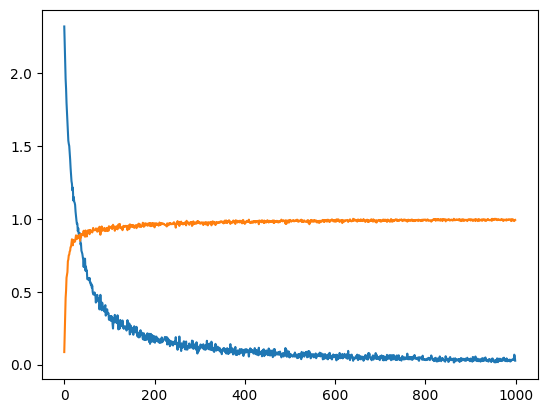

In [273]:
class BroNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(784, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.ReLU()
        )
    def forward(self, x):
        return self.block(x)

model = BroNet()
batch_size = 512
total_steps = 1000
optim = torch.optim.AdamW(model.parameters())
loss_i, acc_i = [], []

def train():
    for i in (t:=trange(total_steps)):
        samp = torch.randint(0, X_tr.shape[0], (batch_size,))
        logits = model(X_tr[samp])
        targets = F.one_hot(Y_tr[samp].long(), num_classes = 10).float()
        loss = F.cross_entropy(logits, targets)
        optim.zero_grad()
        loss.backward()
        optim.step()
        acc = sum(torch.argmax(logits, dim=1) == Y_tr[samp]) / batch_size
        t.set_description(f'loss {loss:8.4f} acc {acc:8.4f}')
        loss_i.append(loss.item())
        acc_i.append(acc.item())

def eval(mode):
    x, y = {
            'train': (X_tr, Y_tr),
            'val': (X_val, Y_val),
            'test': (X_test, Y_test)
    }[mode]
    logits = model(x)
    acc = sum(torch.argmax(logits, dim=1) == y) / x.shape[0]
    print(f'{mode} {acc:8.4f}')

train()
eval('train')
eval('val')
eval('test')
plt.plot(loss_i)
plt.plot(acc_i)
plt.show()


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([32, 10])


TypeError: unsupported format string passed to Tensor.__format__